## Draw a plot of meter coverage over time (saturating curve plot)

## Write down procedures to cut down preprocessing and clean up

In [2]:
import numpy as np
import time
from numba import njit

In [6]:
# CONSTANTS
NO_METERS_P = 108
NO_POLES_P = 117
NO_METERS_C = 7172
NO_POLES_C = 6550

In [71]:
@njit 
def preprocessing_rows(a, p):
    x, y = a.shape
    contained = np.zeros(x, dtype=np.bool_)
    sums = np.sum(a, axis = 1)
    for i in range(p):
        #print(i)
        if (sums[i] == 0): continue
        for j in range(i+1, x):
            if (sums[j] < sums[i]): continue
            if i != j and not contained[j]:
                equal = True
                for k in range(y):
                    if a[i, k] > a[j, k]:
                        equal = False
                        break
                contained[j] = equal
    return contained


In [23]:
preprocessing_rows(Adj_pm)

array([False, False, False, ..., False, False, False])

In [22]:
# Preprocessing included greedy algorithm
data_file = np.loadtxt('cap360.txt', dtype=np.int32)
# Create a meters x poles matrix
Adj_pm = np.zeros((NO_METERS_C, NO_POLES_C))
# another modifiable matrix 
Mod_adj_pm = np.zeros((NO_METERS_C, NO_POLES_C))
for x in data_file:
    x[0] -= 1 # Converting to 0-index
    x[1] -= 1
    Adj_pm[x[0]][x[1]] = 1
    Mod_adj_pm[x[0]][x[1]] = 1

start_time = time.time()
# Create an zero vector for covered meters (assigned 0 for uncovered meters)
cov_meters = np.zeros(NO_METERS_C)
# list of covered meters
list_cov_meters = []
# list of covering poles
list_cov_poles = []
total = 0
nps = 10
prep_ctr = 5
while (np.any(cov_meters == 0)): # until all meters are covered
        # Preprocessing (nps(no of preprocessing steps) times):    
        # 1. Removing singleton rows
        singleton_rows = [int(x) for x in np.argwhere(np.sum(Mod_adj_pm, axis = 1) == 1)] # sum along all rows and see if it is 1
        if singleton_rows: # if there is atleast one singleton row
            for i in range(len(singleton_rows)):
                if (np.sum(Mod_adj_pm[singleton_rows[i]]) == 1):
                    pole = int(np.argwhere(Mod_adj_pm[singleton_rows[i], :] == 1))
                    list_cov_poles.append(pole)        
                    x = Adj_pm[:, pole]
                    met_poles = [int(m) for m in np.argwhere(x == 1)] 
                    scores -= np.sum(Mod_adj_pm[met_poles], axis = 0)
                    cov_meters[met_poles] += 1
                    Mod_adj_pm[met_poles, :] = 0 
                    print("Pole", pole, " added covering singleton row", singleton_rows[i])

        # 2. Removing rows that contain row j
        if (len(list_cov_poles) % 20 == 0):
            st = time.time()
            contains = preprocessing_rows(Mod_adj_pm)
            #scores -= np.sum(Mod_adj_pm[contains], axis = 0)
            Mod_adj_pm[contains] = 0
            cov_meters[contains] += 1
            print(time.time() - st)
            # 3. Removing columns contained in column j
            st = time.time()
            contains = preprocessing_cols(Mod_adj_pm.T)
            Mod_adj_pm[:, contains] = 0
            scores[contains] = 0 
            print(time.time() - st)

        #####################################################
        # Greedy Algorithm
        indices = np.argmax(scores) # Finds the best pole
        # add the best pole (indices)
        list_cov_poles.append(indices)
        # find the corresponding column in the matrix
        x = Adj_pm[:, indices]
        # find the meters covered by this pole and add to overall covered meters
        # and set the corresponding row of the meter to zero
        met_poles = [int(m) for m in np.argwhere(x == 1)] 
        cov_meters[met_poles] += 1
        scores -= np.sum(Mod_adj_pm[met_poles], axis = 0)
        Mod_adj_pm[met_poles, :] = 0
        #####################################################
        # Clean up
        if(len(list_cov_poles)%1 == 0):
            clean_up_indices = []
            for i in range(0, len(list_cov_poles)): # for each already selected pole(sp)
                sp = list_cov_poles[i]
                meters_by_sp = [int(m) for m in np.argwhere(Adj_pm[:, sp] == 1)] # meters covered by sp
                if (np.any((cov_meters[meters_by_sp]-1) <= 0) == False):
                    clean_up_indices.append(i)
                    cov_meters[meters_by_sp] -= 1
            for j in sorted(clean_up_indices, reverse=True):
                del list_cov_poles[j]
        print("no of poles:", len(list_cov_poles))
        print("no of covered meters:", np.sum(cov_meters != 0))

print("Running time:", (time.time() - start_time))
print("Number of poles:",len(list_cov_poles))

NameError: name 'scores' is not defined

In [15]:
# Preprocessing included greedy algorithm
data_file = np.loadtxt('cap360.txt', dtype=np.int32)
# Create a meters x poles matrix
Adj_pm = np.zeros((NO_METERS_C, NO_POLES_C))
# another modifiable matrix 
Mod_adj_pm = np.zeros((NO_METERS_C, NO_POLES_C))
for x in data_file:
    x[0] -= 1 # Converting to 0-index
    x[1] -= 1
    Adj_pm[x[0]][x[1]] = 1
    Mod_adj_pm[x[0]][x[1]] = 1

start_time = time.time()
# Create an zero vector for covered meters (assigned 0 for uncovered meters)
cov_meters = np.zeros(NO_METERS_C)
# list of covered meters
list_cov_meters = []
# list of covering poles
list_cov_poles = []
total = 0
nps = 10
prep_ctr = 5
while (np.any(cov_meters == 0)):
    #####################################################
    # Preprocessing (nps(no of preprocessing steps) times):
    
    # 1. Removing singleton rows
    # sum along all rows and see if it is 1
    singleton_rows = [int(x) for x in np.argwhere(np.sum(Mod_adj_pm, axis = 1) == 1)] 
    # Add the poles corresponding to the first nps singleton row
    if singleton_rows: # if there is atleast one singleton row
        for i in range(min(len(singleton_rows), nps)):
            if (np.sum(Mod_adj_pm[singleton_rows[i]]) == 1):
                pole = int(np.argwhere(Mod_adj_pm[singleton_rows[i], :] == 1))
                list_cov_poles.append(pole)        
                x = Adj_pm[:, pole]
                met_poles = [int(m) for m in np.argwhere(x == 1)] 
                cov_meters[met_poles] += 1
                Mod_adj_pm[met_poles, :] = 0 
                print("Pole", pole, " added covering ", singleton_rows[i], "row")

    # 2. Removing rows that contain row j
    if (len(list_cov_poles) < 150):
        rows_to_check = np.random.randint(0, NO_METERS_C, nps)
        #if (len(list_cov_poles) < 100):
        for i in rows_to_check:#range(prep_ctr-nps, prep_ctr):
            if (np.sum(Mod_adj_pm[i]) == 0):
                continue
            contains = np.argwhere(np.all(Mod_adj_pm[i, :] <= Mod_adj_pm, axis = 1))
            #print(contains)
            if (contains.shape[0] > 1):
                #print("Rule 2 applied")
                for j in contains:
                    if j > i:
                        Mod_adj_pm[j, :] = 0
                        cov_meters[j] += 1
        # 3. Removing columns contained in column j
        cols_to_check = np.random.randint(0, NO_POLES_C, nps)
        #max_sum = np.max(np.sum(Mod_adj_pm, axis = 0))
        #print(max_sum)
        #cols_to_check = [int(x) for x in np.argwhere(np.sum(Mod_adj_pm, axis = 0) >= max_sum-5)]
        #print(cols_to_check)
        for i in cols_to_check:#range(prep_ctr-nps, prep_ctr):
            contains = np.argwhere(np.all(Mod_adj_pm[:, i] >= Mod_adj_pm.T, axis = 1))
            #print(contains.shape[0])
            if (contains.shape[0] > 1):
                #print("Rule 3 applied")
                for j in contains:
                    if j > i:
                        Mod_adj_pm[:, j] = 0
    prep_ctr += 5
    if (prep_ctr >= NO_METERS_P):
        prep_ctr = 5
    #####################################################
    # Greedy Algorithm
    indices = np.argmax(np.sum(Mod_adj_pm, axis = 0))
    
    # add the best pole (indices)
    list_cov_poles.append(indices)
    #print(np.sum(Mod_adj_pm, axis = 0))
    #print("pole ", indices, "added!")
    # find the corresponding column in the matrix
    x = Adj_pm[:, indices]
    # find the meters covered by this pole and add to overall covered meters
    # and set the corresponding row of the meter to zero
    met_poles = [int(m) for m in np.argwhere(x == 1)] # time in orders of 10-4
    cov_meters[met_poles] += 1
    Mod_adj_pm[met_poles, :] = 0
    #print(met_poles)
    # Clean up
    if (len(list_cov_poles)):
        clean_up_indices = []
        for i in range(0, len(list_cov_poles)): # for each already selected pole(sp)
            sp = list_cov_poles[i]
            meters_by_sp = [int(m) for m in np.argwhere(Adj_pm[:, sp] == 1)] # meters covered by sp
            if (np.any((cov_meters[meters_by_sp]-1) <= 0) == False):
                clean_up_indices.append(i)
                print("\nremoving ", sp)
                cov_meters[meters_by_sp] -= 1
        st = time.time()
        for j in sorted(clean_up_indices, reverse=True):
            del list_cov_poles[j]
        total += (time.time()-st)
    print("no of poles:", len(list_cov_poles))
    print("no of covered meters:", np.sum(cov_meters != 0))
print((time.time() - start_time))
print(len(list_cov_poles))
print(total)
#print(list_cov_poles)

57.0
no of poles: 1
no of covered meters: 57
57.0
no of poles: 2
no of covered meters: 114
54.0
no of poles: 3
no of covered meters: 168
51.0
no of poles: 4
no of covered meters: 219
50.0
no of poles: 5
no of covered meters: 269
50.0
no of poles: 6
no of covered meters: 319
49.0
no of poles: 7
no of covered meters: 368
49.0
no of poles: 8
no of covered meters: 417
48.0
no of poles: 9
no of covered meters: 465
48.0
no of poles: 10
no of covered meters: 513
46.0
no of poles: 11
no of covered meters: 559
46.0
no of poles: 12
no of covered meters: 605
46.0
no of poles: 13
no of covered meters: 651
46.0
no of poles: 14
no of covered meters: 697
45.0
no of poles: 15
no of covered meters: 742
44.0
no of poles: 16
no of covered meters: 786
44.0
no of poles: 17
no of covered meters: 830
44.0
no of poles: 18
no of covered meters: 874
43.0
no of poles: 19
no of covered meters: 917
43.0
no of poles: 20
no of covered meters: 960
43.0
no of poles: 21
no of covered meters: 1003
42.0
no of poles: 22
n

KeyboardInterrupt: 

In [14]:
x = np.array([[0, 0, 0], [1, 1, 1]])

In [15]:
x

array([[0, 0, 0],
       [1, 1, 1]])

In [17]:
x.sum(axis=1)

array([0, 3])

In [23]:
for j in range(NO_POLES_C):
    print(j)
    for k in range(NO_POLES_C):
        if(np.all(Adj_pm[:, j] <= Adj_pm[:, k]) and j!=k): 
            print("column ", k, "contains column", j)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176


KeyboardInterrupt: 

In [50]:
np.all(Adj_pm[0] <= Adj_pm[2])

False

In [51]:
np.all(Adj_pm[0] <= Adj_pm, axis = 1)

array([ True, False, False, ..., False, False, False])

In [62]:
Adj_pm.T.shape

(6550, 7172)

In [66]:
Adj_pm.T[0]

2.0

In [69]:
np.argwhere(np.all(Adj_pm[:, 0] <= Adj_pm.T, axis = 1))

array([[0]])

In [56]:
for i in range(NO_POLES_C):
    print(i)
    if (np.argwhere(np.all(Adj_pm[:, i] <= Adj_pm[:, :], axis = 1)).shape[0] > 1):
        print(i, 'has')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: 

In [70]:
for i in range(NO_POLES_C):
    print(i)
    if (np.argwhere(np.all(Adj_pm[:, i] <= Adj_pm.T, axis = 1)).shape[0] > 1):
        print(i, 'has')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: 

In [ ]:
x = np.array([[6, 4, 5], [2, 2, 7]])

In [70]:
x

array([[6, 4, 5],
       [2, 2, 7]])

In [77]:
np.all(x[1] <= x, axis = 1)

array([False,  True])

In [87]:
x[:, 0] <= x.T

array([[ True,  True],
       [ True,  True],
       [ True, False]])

In [88]:
np.all(x[:, 0] <= x.T, axis = 1)

array([ True,  True, False])

In [79]:
np.greater_equal(x[, x)

array([ True,  True])

In [32]:
p = np.argwhere(np.all(x[:, 1] <= x.T, axis = 1))

In [36]:
for i in range(p)

SyntaxError: invalid syntax (<ipython-input-36-27716b662b21>, line 1)

In [38]:
for j in p:
    print(x[j])

[[6 4 5]]
[[2 2 7]]


IndexError: index 2 is out of bounds for axis 0 with size 2

In [82]:
st = time.time()
for i in range(NO_METERS_C):
    if (np.sum(Adj_pm[i]) == 0):
        continue
    contains = np.argwhere(np.all(Adj_pm[i, :] <= Adj_pm[i+1:, :], axis = 1))
print(time.time() - st)


164.8810260295868


In [83]:
a = np.array([[2,1,3,3],[2,3,3,4],[4,1,3,2]])

In [88]:
len(a)

3

In [97]:
R,C = np.triu_indices(len(Adj_pm),1)


In [99]:
R.shape

(25715206,)

In [101]:
C.shape

(25715206,)

In [ ]:
(Adj_pm >= Adj_pm[:, None]).all(-1)

In [6]:
np.sum(Adj_pm, axis = 1) == 0

array([False, False, False, ..., False, False, False])

In [39]:
Adj_pm = np.array([[1, 1, 0, 1, 0, 0], [1, 1, 0, 1, 0, 0], 
          [0, 0, 1, 0, 1, 0], [0, 0, 1, 0, 1, 1], 
          [0, 0, 1, 0, 0, 1], [0, 0, 0, 0, 0, 1]])
Mod_adj_pm = np.array([[1, 1, 0, 1, 0, 0], [1, 1, 0, 1, 0, 0], 
          [0, 0, 1, 0, 1, 0], [0, 0, 1, 0, 1, 1], 
          [0, 0, 1, 0, 0, 1], [0, 0, 0, 0, 0, 1]])
start_time = time.time()
# Create an zero vector for covered meters (assigned 0 for uncovered meters)
cov_meters = np.zeros(6)
# list of covered meters
list_cov_meters = []
# list of covering poles
list_cov_poles = []
total = 0
nps = 1
prep_ctr = 1
while (np.any(cov_meters == 0)):
    #####################################################
    # Preprocessing (nps(no of preprocessing steps) times):
    
    # 1. Removing singleton rows
    # sum along all rows and see if it is 1
    singleton_rows = [int(x) for x in np.argwhere(np.sum(Mod_adj_pm, axis = 1) == 1)] 
    # Add the poles corresponding to the first nps singleton row
    if singleton_rows: # if there is atleast one singleton row
        for i in range(min(len(singleton_rows), nps)):
            if (np.sum(Mod_adj_pm[singleton_rows[i]]) == 1):
                pole = int(np.argwhere(Mod_adj_pm[singleton_rows[i], :] == 1))
                list_cov_poles.append(pole)        
                x = Adj_pm[:, pole]
                met_poles = [int(m) for m in np.argwhere(x == 1)] 
                cov_meters[met_poles] += 1
                Mod_adj_pm[met_poles, :] = 0 
                print("Pole", pole, " added covering ", singleton_rows[i], "row")

    # 2. Removing rows that contain row j
    rows_to_check = np.random.randint(0, NO_METERS_C, nps)
    #if (len(list_cov_poles) < 100):
    for i in range(prep_ctr-nps, prep_ctr):
        if (np.sum(Mod_adj_pm[i]) == 0):
            continue
        contains = np.argwhere(np.all(Mod_adj_pm[i, :] <= Mod_adj_pm, axis = 1))
        #print(contains)
        if (contains.shape[0] > 1):
            #print("Rule 2 applied")
            for j in contains:
                if j != i:
                    Mod_adj_pm[j, :] = 0
                    cov_meters[j] += 1
    # 3. Removing columns contained in column j
    #cols_to_check = np.random.randint(0, NO_POLES_C, nps)
    for i in range(prep_ctr-nps, prep_ctr):
        contains = np.argwhere(np.all(Mod_adj_pm[:, i] >= Mod_adj_pm.T, axis = 1))
        #print(contains.shape[0])
        if (contains.shape[0] > 1):
            #print("Rule 3 applied")
            for j in contains:
                if j != i:
                    Mod_adj_pm[:, j] = 0
    prep_ctr += 1
    if (prep_ctr >= 6):
        prep_ctr = 1
    #####################################################
    # Greedy Algorithm
    indices = np.argmax(np.sum(Mod_adj_pm, axis = 0))
    
    # add the best pole (indices)
    list_cov_poles.append(indices)
    #print(np.sum(Mod_adj_pm, axis = 0))
    #print("pole ", indices, "added!")
    # find the corresponding column in the matrix
    x = Adj_pm[:, indices]
    # find the meters covered by this pole and add to overall covered meters
    # and set the corresponding row of the meter to zero
    met_poles = [int(m) for m in np.argwhere(x == 1)] # time in orders of 10-4
    cov_meters[met_poles] += 1
    Mod_adj_pm[met_poles, :] = 0
    #print(met_poles)
    # Clean up
    if (len(list_cov_poles)):
        clean_up_indices = []
        for i in range(0, len(list_cov_poles)): # for each already selected pole(sp)
            sp = list_cov_poles[i]
            meters_by_sp = [int(m) for m in np.argwhere(Adj_pm[:, sp] == 1)] # meters covered by sp
            if (np.any((cov_meters[meters_by_sp]-1) <= 0) == False):
                clean_up_indices.append(i)
                print("\nremoving ", sp)
                cov_meters[meters_by_sp] -= 1
        st = time.time()
        for j in sorted(clean_up_indices, reverse=True):
            del list_cov_poles[j]
        total += (time.time()-st)
    print("no of poles:", len(list_cov_poles))
    print("no of covered meters: ", np.sum(cov_meters != 0))
    print("meters", cov_meters)
print((time.time() - start_time))
print(len(list_cov_poles))
print(total)
print(list_cov_poles)

Pole 5  added covering  5 row
no of poles: 2
no of covered meters:  5
meters [1. 2. 0. 1. 1. 1.]
no of poles: 3
no of covered meters:  6
meters [1. 2. 1. 2. 2. 1.]
0.003904104232788086
3
1.0013580322265625e-05
[5, 0, 2]


In [18]:
import matplotlib.pyplot as plt

(array([ 699.,  618.,  769.,  832., 1241., 1024.,  883.,  326.,  131.,
          27.]),
 array([ 2. ,  7.5, 13. , 18.5, 24. , 29.5, 35. , 40.5, 46. , 51.5, 57. ]),
 <a list of 10 Patch objects>)

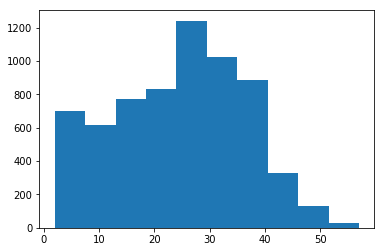

In [58]:
plt.hist(np.sum(Adj_pm, axis = 0))

In [24]:
time = [74, 84, 243, 278]
value = [632, 618, 615, 602]
t_value = [0, 1, 2, 3]

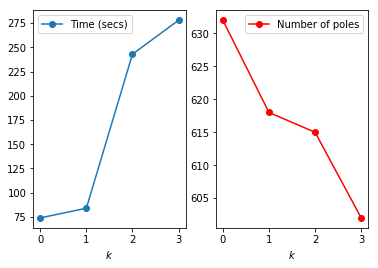

In [48]:
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(t_value, time, label ='Time (secs)', marker='o')
axes[1].plot(t_value, value, label ='Number of poles', marker='o', color='r')
axes[0].set_xlabel("$k$")
axes[1].set_xlabel("$k$")
axes[0].legend()
axes[1].legend()
plt.savefig("modified_greedy.pdf")

In [64]:
import time

In [70]:
iter_list = [100, 200, 400, 800, 1000]
time_list = []
for j in iter_list:
    st = time.time()
    for i in range(j):
        #print(i)
        contains = np.argwhere(np.all(Adj_pm.T[i, :] >= Adj_pm.T, axis = 1))
    #print(time.time() - st)
    time_list.append(time.time() - st)
    print(time_list[-1])

5.876302003860474
10.505511283874512
18.801680088043213
41.08252692222595
51.52135920524597


In [69]:
time_list

[4.8062968254089355,
 9.37040901184082,
 22.1769380569458,
 46.62206411361694,
 53.93047475814819]

In [76]:
@njit 
def preprocessing_rows(a, p=1000):
    x, y = a.shape
    contained = np.zeros(x, dtype=np.bool_)
    sums = np.sum(a, axis = 1)
    for i in range(p):
        #print(i)
        if (sums[i] == 0): continue
        for j in range(i+1, x):
            if (sums[j] < sums[i]): continue
            if i != j and not contained[j]:
                equal = True
                for k in range(y):
                    if a[i, k] > a[j, k]:
                        equal = False
                        break
                contained[j] = equal
    return contained


In [77]:
preprocessing_rows(Adj_pm)

KeyboardInterrupt: 

In [72]:
iter_list = [100, 200, 400, 800, 1000]
njt_time_list = []
for j in iter_list:
    st = time.time()
    for i in range(j):
        #print(i)
        contains = preprocessing_rows(Adj_pm, i)
    #print(time.time() - st)
    njt_time_list.append(time.time() - st)
    print(njt_time_list[-1])

37.05850601196289
81.51587080955505


KeyboardInterrupt: 